# E-commerce Sales Data Analysis Project

# Importing the basic libraries

In [1]:
import os
import sys

# Prevent MKL / KMeans warning on Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Allow imports from src/
sys.path.append("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

from statsmodels.tsa.statespace.sarimax import SARIMAX

from src.data_loader import load_sales_data
from src.analysis import (
    add_total_amount,
    add_shipping_delay,
    add_high_discount_flag,
    build_monthly_sales,
    evaluate_classifier
)

In [3]:
!pip -q install plotly

In [4]:
!pip -q install yellowbrick

# Step 1: Integration and Initial Analysis

## 1.1 Load ecommerce_sales.csv and Display the First 10 Rows

In [5]:
from src.data_loader import load_sales_data

ecommerce = load_sales_data("../data/ecommerce_sales.csv")

In [6]:
ecommerce.head(10)


,OrderID,CustomerID,OrderDate,ShipDate,ProductCategory,ProductID,Quantity,UnitPrice,Discount,TotalAmount,Region
0,ORD1000,CUST151,2024-05-10,2024-05-12,Clothing,PID1099,4,190.46,0.10,685.66,North
1,ORD1001,CUST192,2024-04-12,2024-04-12,Books,PID1033,3,147.89,0.10,399.30,Central
2,ORD1002,CUST114,2024-07-17,2024-07-22,Books,PID1051,5,126.55,0.00,632.75,North
3,ORD1003,CUST171,2024-02-21,2024-02-22,Books,PID1094,5,89.47,0.15,380.25,North
4,ORD1004,CUST160,2024-10-19,2024-10-19,Electronics,PID1009,3,187.22,0.10,505.49,North
5,ORD1005,CUST120,2024-01-28,2024-01-28,Electronics,PID1018,9,174.55,0.00,1570.95,East
6,ORD1006,CUST182,2024-12-26,2024-12-28,Electronics,PID1057,4,18.59,0.20,59.49,East
7,ORD1007,CUST186,2024-10-08,2024-10-11,Clothing,PID1095,5,15.01,0.20,60.04,North
8,ORD1008,CUST174,2024-03-13,2024-03-13,Toys,PID1000,4,81.53,0.00,326.12,Central
9,ORD1009,CUST174,2024-01-03,2024-01-05,Books,PID1068,5,164.01,0.00,820.05,West


## 1.2 Description of the Structure

a. Dataset Dimensions

In [7]:
ecommerce.shape

(100, 11)

b. Data Types

In [8]:
ecommerce.dtypes

OrderID             object
CustomerID          object
OrderDate           object
ShipDate            object
ProductCategory     object
ProductID           object
Quantity             int64
UnitPrice          float64
Discount           float64
TotalAmount        float64
Region              object
dtype: object

c. Counting Missing Values

In [9]:
ecommerce.isnull().sum()

OrderID            0
CustomerID         0
OrderDate          0
ShipDate           0
ProductCategory    0
ProductID          0
Quantity           0
UnitPrice          0
Discount           0
TotalAmount        0
Region             0
dtype: int64

d. Basic Descriptive Statistics

In [10]:
ecommerce[['TotalAmount', 'Quantity', 'UnitPrice']].describe()

,TotalAmount,Quantity,UnitPrice
count,100.000000,100.000000,100.000000
mean,491.051300,5.150000,103.968000
std,359.554869,2.471555,56.926465
min,12.760000,1.000000,12.760000
25%,199.442500,3.000000,50.145000
50%,415.310000,5.000000,99.550000
75%,704.055000,7.000000,156.267500
max,1614.820000,9.000000,199.950000


# Step 2: Data Cleansing and Enrichment

## 2.1 Handling Missing Values

a. Fill in ‘Discount’ with zero

In [11]:
ecommerce['Discount'] = ecommerce['Discount'].fillna(0)

b. Remove rows without 'ShipDate'

In [12]:
ecommerce = ecommerce[ecommerce['ShipDate'].notnull()]

## 2.2 Format Conversion

a. Convert 'OrderDate' and 'ShipDate' to datetime

In [13]:
ecommerce['OrderDate'] = pd.to_datetime(ecommerce['OrderDate'])
ecommerce['ShipDate'] = pd.to_datetime(ecommerce['ShipDate'])

b. Calculate 'ShippingDelay' (in days)

In [14]:
ecommerce['ShippingDelay'] = (ecommerce['ShipDate'] - ecommerce['OrderDate']).dt.days

## 2.3 Outlier Correction

a. Set limits based on percentiles for 'UnitPrice' and 'Quantity'

In [15]:
Q1_price = ecommerce['UnitPrice'].quantile(0.25)
Q3_price = ecommerce['UnitPrice'].quantile(0.75)
price_lower = Q1_price - 1.5 * (Q3_price - Q1_price)
price_upper = Q3_price + 1.5 * (Q3_price - Q1_price)

Q1_qty = ecommerce['Quantity'].quantile(0.25)
Q3_qty = ecommerce['Quantity'].quantile(0.75)
qty_lower = Q1_qty - 1.5 * (Q3_qty - Q1_qty)
qty_upper = Q3_qty + 1.5 * (Q3_qty - Q1_qty)

b. Replace values outside the limits with the limits themselves

In [16]:
ecommerce['UnitPrice'] = ecommerce['UnitPrice'].clip(lower=price_lower, upper=price_upper)
ecommerce['Quantity'] = ecommerce['Quantity'].clip(lower=qty_lower, upper=qty_upper)

c. Display summary after transformation

In [17]:
ecommerce['OrderYear'] = ecommerce['OrderDate'].dt.year
ecommerce['OrderMonth'] = ecommerce['OrderDate'].dt.month

ecommerce[['OrderDate', 'OrderYear', 'OrderMonth', 'ShipDate', 'ShippingDelay', 'Quantity', 'UnitPrice']].head()


,OrderDate,OrderYear,OrderMonth,ShipDate,ShippingDelay,Quantity,UnitPrice
0,2024-05-10,2024,5,2024-05-12,2,4,190.46
1,2024-04-12,2024,4,2024-04-12,0,3,147.89
2,2024-07-17,2024,7,2024-07-22,5,5,126.55
3,2024-02-21,2024,2,2024-02-22,1,5,89.47
4,2024-10-19,2024,10,2024-10-19,0,3,187.22


# Step 3: Exploratory Analysis and Visualizations

## 3.1 Monthly Sales Time Series

a. Group by year and month

In [18]:
monthly_sales = (
    ecommerce
    .groupby(['OrderYear', 'OrderMonth'])['TotalAmount']
    .sum()
    .reset_index()
)

b. Create date column

In [19]:
monthly_sales['YearMonth'] = pd.to_datetime(
    monthly_sales['OrderYear'].astype(str) + '-' + monthly_sales['OrderMonth'].astype(str) + '-01'
)

c. Plot

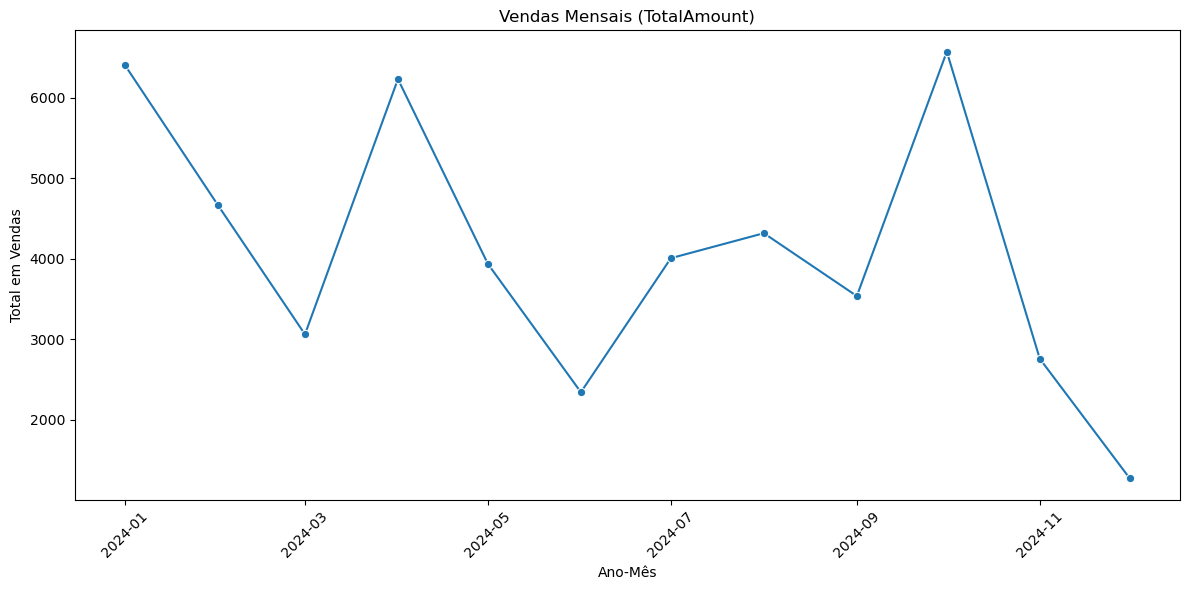

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='TotalAmount', marker='o')
plt.title('Vendas Mensais (TotalAmount)')
plt.xlabel('Ano-Mês')
plt.ylabel('Total em Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.2 Top 5 Product Categories by Revenue

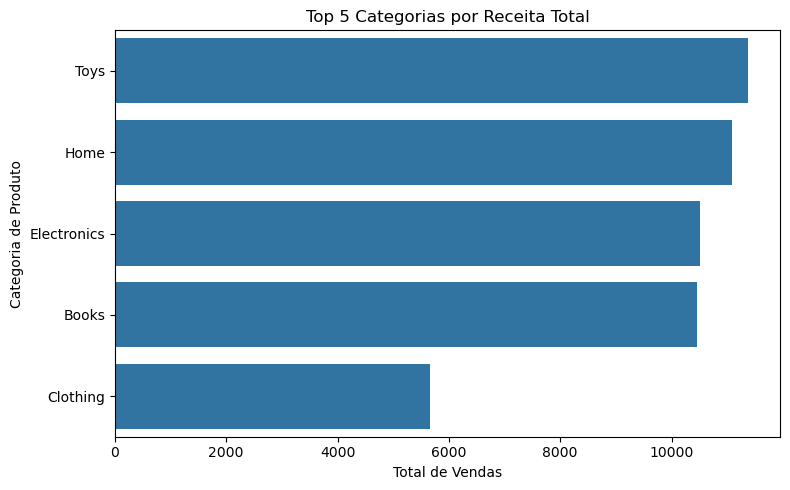

In [21]:
top_categories = (
    ecommerce.groupby('ProductCategory')['TotalAmount']
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 5 Categorias por Receita Total')
plt.xlabel('Total de Vendas')
plt.ylabel('Categoria de Produto')
plt.tight_layout()
plt.show()

## 3.3 Distribution of ShippingDelay (Histogram + Boxplot)

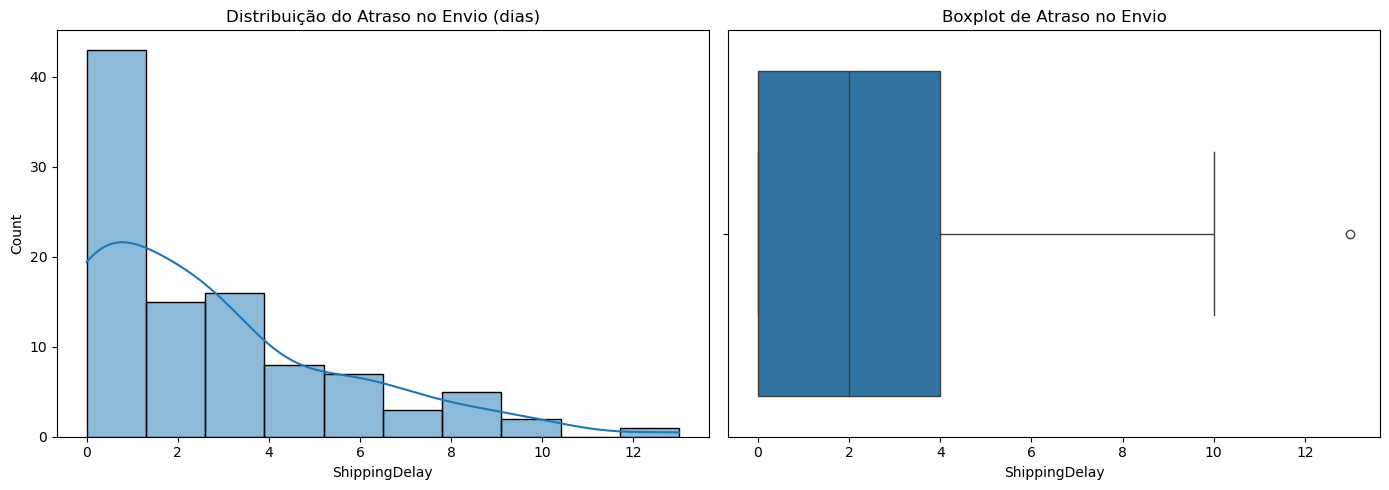

In [22]:
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(ecommerce['ShippingDelay'], bins=10, kde=True)
plt.title('Distribuição do Atraso no Envio (dias)')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=ecommerce['ShippingDelay'])
plt.title('Boxplot de Atraso no Envio')

plt.tight_layout()
plt.show()

## 3.4 Color Map of Numerical Correlations

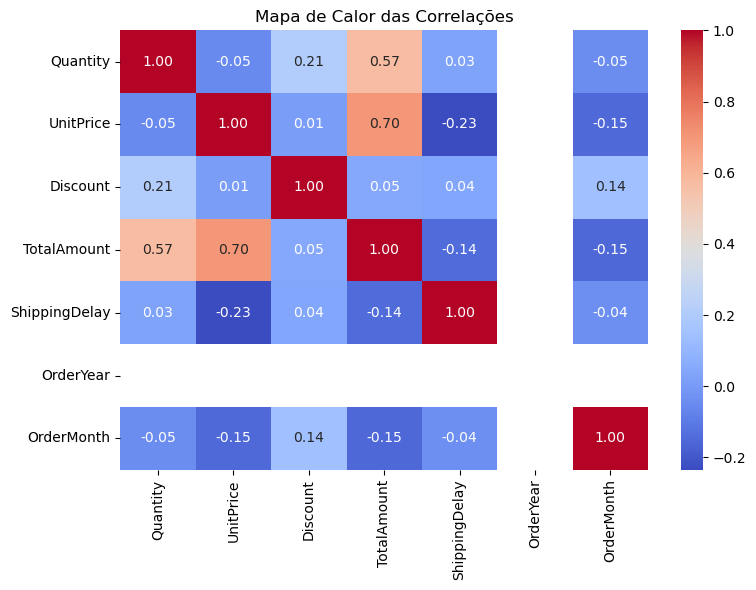

In [23]:
plt.figure(figsize=(8, 6))
correlation = ecommerce.select_dtypes(include='number').corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor das Correlações')
plt.tight_layout()
plt.show()

# Step 4: Modeling and Advanced Analysis

## 4.1 Monthly Sales Forecast (ARIMA and Prophet)

In [24]:
# Prerequisites
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    PROPHET_AVAILABLE = False

if PROPHET_AVAILABLE:
    train_prophet = df_prophet.iloc[:-6]
    test_prophet = df_prophet.iloc[-6:]

    model_prophet = Prophet()
    model_prophet.fit(train_prophet)

    future = model_prophet.make_future_dataframe(periods=6, freq='MS')
    forecast = model_prophet.predict(future)
else:
    print("Prophet not installed. Skipping Prophet forecasting.")

# Monthly time series
ts = (
    monthly_sales
    .set_index("YearMonth")["TotalAmount"]
    .asfreq("MS")
)

monthly_sales = build_monthly_sales(ecommerce)

# Split into training/testing
train = ts.iloc[:-6]
test = ts.iloc[-6:]

# --- SARIMA ---
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
sarima_fit = model.fit(disp=False)
pred_sarima = sarima_fit.predict(start=test.index[0], end=test.index[-1])

# SARIMA Metrics
mae_sarima = mean_absolute_error(test, pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test, pred_sarima))

# Note: Dataset is relatively small for SARIMAX.
# Results should be interpreted as illustrative rather than statistically robust.

# Print Results
print(f"SARIMA -> MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

if PROPHET_AVAILABLE:
    print(f"Prophet -> MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")
else:
    print("Prophet -> skipped (dependency not installed)")


Prophet not installed. Skipping Prophet forecasting.
SARIMA -> MAE: 1756.75, RMSE: 2131.46
Prophet -> skipped (dependency not installed)


C:\Users\csalv\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\csalv\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\csalv\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\csalv\anaconda3\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\csalv\anaconda3\Lib\site-pac

## 4.2 Customer Segmentation (RFM + K-Means)

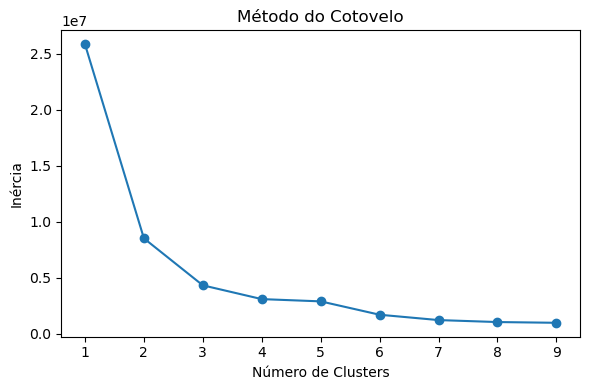

         Recency  Frequency  MonetaryValue
Cluster                                   
0         136.64       1.82         919.73
1         158.79       1.11         279.79
2         131.00       2.64        1912.47


In [25]:
# Latest date in the dataset
ref_date = ecommerce['OrderDate'].max()

# RFM
rfm = ecommerce.groupby('CustomerID').agg({
    'OrderDate': lambda x: (ref_date - x.max()).days,
    'OrderID': 'count',
    'TotalAmount': 'sum'
}).rename(columns={
    'OrderDate': 'Recency',
    'OrderID': 'Frequency',
    'TotalAmount': 'MonetaryValue'
})

# K-Means and Elbow Method
distortions = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm)
    distortions.append(km.inertia_)

# Elbow Plot
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.tight_layout()
plt.show()

# Apply K=3 (or according to Elbow)
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm)

# Cluster description
print(rfm.groupby('Cluster').mean().round(2))

## 4.3 Classification of Effective Discounts (Random Forest and Logistic Regression)

In [26]:
# Target variable
ecommerce['HighDiscount'] = (ecommerce['Discount'] >= 0.2).astype(int)

# Functions and labels
features = ecommerce[['Quantity', 'UnitPrice', 'ShippingDelay', 'TotalAmount']]
labels = ecommerce['HighDiscount']

# Division
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# Evaluation
from sklearn.metrics import precision_score, recall_score, roc_auc_score

metrics_rf = evaluate_classifier(y_test, pred_rf)
metrics_lr = evaluate_classifier(y_test, pred_lr)

print("\nRandom Forest")
print(metrics_rf)

print("\nLogistic Regression")
print(metrics_lr)


Random Forest
{'roc_auc': 0.5, 'precision': 0.0, 'recall': 0.0}

Logistic Regression
{'roc_auc': 0.5, 'precision': 0.0, 'recall': 0.0}


# Step 5: Export Charts

In [27]:
# Create directory to save the graphs
os.makedirs("graficos", exist_ok=True)

# 1. Vendas Mensais
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='TotalAmount', marker='o')
plt.title('Vendas Mensais (TotalAmount)')
plt.xlabel('Ano-Mês')
plt.ylabel('Total em Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("graficos/vendas_mensais.png")
plt.close()

# 2. Top 5 Categories
plt.figure(figsize=(8, 5))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 5 Categorias por Receita Total')
plt.xlabel('Total de Vendas')
plt.ylabel('Categoria de Produto')
plt.tight_layout()
plt.savefig("graficos/top_categorias.png")
plt.close()

# 3. Distribution of 'ShippingDelay'
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(ecommerce['ShippingDelay'], bins=10, kde=True)
plt.title('Distribuição do Atraso no Envio (dias)')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=ecommerce['ShippingDelay'])
plt.title('Boxplot de Atraso no Envio')

plt.tight_layout()
plt.savefig("graficos/shipping_delay.png")
plt.close()

# 4. Correlation Heat Map
plt.figure(figsize=(8, 6))
correlation = ecommerce.select_dtypes(include='number').corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor das Correlações')
plt.tight_layout()
plt.savefig("graficos/mapa_correlacoes.png")
plt.close()

# 5. Elbow Method - KMeans
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.tight_layout()
plt.savefig("graficos/kmeans_elbow.png")
plt.close()

# Step 6: Detailed Programming Exercises

## 6.1 Manual Statistics (Mean, Median, Standard Deviation)

In [28]:
def calculate_mean(prices: list[float]) -> float:
    """
    Calcula a média de uma lista de preços.

    :param prices: Lista de valores (floats)
    :return: Média dos valores
    """
    total = 0
    for price in prices:
        total += price
    return total / len(prices) if prices else 0

# Test
assert round(calculate_mean([10.0, 20.0, 30.0]), 2) == 20.0

In [29]:
def calculate_median(prices: list[float]) -> float:
    """
    Calcula a mediana manualmente.

    :param prices: Lista de floats
    :return: Mediana
    """
    sorted_prices = sorted(prices)
    n = len(sorted_prices)
    mid = n // 2
    if n % 2 == 0:
        return (sorted_prices[mid - 1] + sorted_prices[mid]) / 2
    else:
        return sorted_prices[mid]

# Test
assert calculate_median([3, 1, 2]) == 2

In [30]:
def calculate_std(prices: list[float]) -> float:
    """
    Calcula o desvio-padrão populacional passo a passo.

    :param prices: Lista de floats
    :return: Desvio-padrão populacional
    """
    mean = calculate_mean(prices)
    variance = sum((p - mean) ** 2 for p in prices) / len(prices)
    return variance ** 0.5

# Test
assert round(calculate_std([2, 4, 4, 4, 5, 5, 7, 9]), 2) == 2.0

In [31]:
def calculate_stats(values: list[float]) -> dict[str, float]:
    """
    Retorna dicionário com média, mediana e desvio-padrão.

    :param values: Lista de floats
    :return: Dicionário {"mean": ..., "median": ..., "std": ...}
    """
    return {
        "mean": calculate_mean(values),
        "median": calculate_median(values),
        "std": calculate_std(values)
    }

# Test
assert calculate_stats([1, 2, 3])["mean"] == 2

## 6.2 Conditionals and Logic

In [32]:
def classify_value_order(total: float) -> str:
    """
    Classifica um pedido com base no total.
    """
    if total >= 1000:
        return "HighValue"
    elif total >= 500:
        return "MidValue"
    else:
        return "LowValue"

# Test
assert classify_value_order(800) == "MidValue"

In [33]:
def count_orders_by_region(ecommerce: pd.DataFrame) -> dict[str, int]:
    """
    Conta quantos pedidos existem por categoria de valor.
    """
    counts = {"HighValue": 0, "MidValue": 0, "LowValue": 0}
    for _, row in ecommerce.iterrows():
        category = classify_value_order(row['TotalAmount'])
        counts[category] += 1
    return counts

In [34]:
def classify_value_advanced(total: float, discount: float, quantity: int) -> str:
    """
    Classifica pedidos com lógica estendida.
    """
    if total >= 1000 or (discount >= 0.2 and quantity > 10):
        return "HighValue"
    elif total >= 500:
        return "MidValue"
    else:
        return "LowValue"

6.3 Repetition Structures and Dictionaries

In [35]:
# Nested loop
def revenue_by_region_category(ecommerce: pd.DataFrame) -> dict[str, dict[str, float]]:
    result = {}
    for _, row in ecommerce.iterrows():
        region = row['Region']
        category = row['ProductCategory']
        amount = row['TotalAmount']
        if region not in result:
            result[region] = {}
        if category not in result[region]:
            result[region][category] = 0
        result[region][category] += amount
    return result

In [36]:
# Comprehension
def revenue_by_region_category_comp(ecommerce: pd.DataFrame) -> dict[str, dict[str, float]]:
    return {
        region: {
            category: ecommerce[(ecommerce['Region'] == region) & (ecommerce['ProductCategory'] == category)]['TotalAmount'].sum()
            for category in ecommerce['ProductCategory'].unique()
        }
        for region in ecommerce['Region'].unique()
    }

6.4 Collections: List, Set, Dict

In [37]:
order_list = [(row['OrderID'], row['TotalAmount']) for _, row in ecommerce.iterrows()]
unique_customers = set(ecommerce['CustomerID'])
product_quantities = {
    pid: ecommerce[ecommerce['ProductID'] == pid]['Quantity'].sum()
    for pid in ecommerce['ProductID'].unique()
}

In [38]:
from collections import defaultdict, Counter

product_quantities_dd = defaultdict(int)
for _, row in ecommerce.iterrows():
    product_quantities_dd[row['ProductID']] += row['Quantity']

product_counter = Counter(ecommerce['ProductID'])

6.5 Functions, Iterators, and Generators

In [39]:
from typing import Iterator

def order_batch(ecommerce: pd.DataFrame, batch_size: int) -> Iterator[pd.DataFrame]:
    for start in range(0, len(ecommerce), batch_size):
        yield ecommerce.iloc[start:start + batch_size]

In [40]:
def delayed_orders(ecommerce: pd.DataFrame) -> list[dict]:
    return list(filter(lambda d: d['ShippingDelay'] > 7, ecommerce.to_dict(orient='records')))